# Exemple sur le modèle jouet Campbell

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
%load_ext autoreload #permet de ne pas restart le kernel à chaque modif de nos fichiers python
%autoreload 2

#import kernels
import methods

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

#x=np.array([-1,-1,-1,-1,-1,-1,-1,-1])
#x=np.array([5,5,5,5,5,5,5,5])
x=np.array([5,3,1,-1,5,3,1,-1])

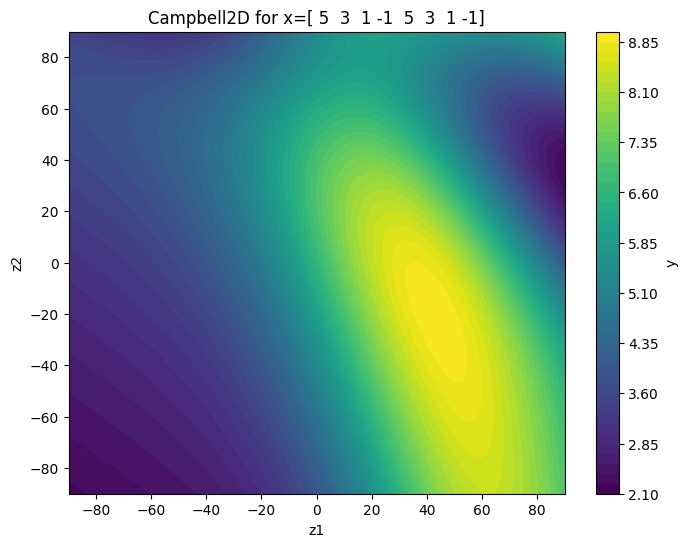

In [50]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

Y = Simulateur(x, Z1, Z2)
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for x={x}')
plt.show()

In [51]:
n_train = 200
x_train=np.random.uniform(-1,5,(n_train,8)) #on simule les données d'entrée avec une loi uniforme
y_train = np.zeros((n_train,n_grid*n_grid))  # matrice (1000, 4096)
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()
print("Forme de y_train :",y_train.shape)

n_test = 1000
x_test=np.random.uniform(-1,5,(n_test,8))
y_test = np.zeros((n_test,n_grid*n_grid))
for i in range(n_test):
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()
print("Forme de y_test :",y_test.shape)

Forme de y_train : (200, 4096)
Forme de y_test : (1000, 4096)


## Méthode par ACP

In [52]:
#La fonction est dans le fichier methods.py
n_pc = 5 #nombre composantes principales
theta = 3
sigma = 1
Y_test_reconstruct_ACP = methods.ACP(x_test,x_test,y_test,n_pc,[theta,sigma]) 


taille du vecteur de y_train: (1000, 4096)
Variance expliquée par les 5 premières composantes : [0.78957059 0.12822378 0.02712022 0.01704608 0.01580746]
Variance globale expliquée : 0.9777681262249049
Taille du jeu d'entrainement transformé par ACP : (1000, 5)
taille du vecteur de Y_test_reconstruct: (1000, 4096)


# Méthode par B-Splines

In [53]:
t1 = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("vecteur de noeuds",t1)
Y_test_reconstruct_Bsplines = methods.Bsplines_ACP(x_train, x_test, y_train,t1, t1, n_pc, [theta,sigma], degree=1)

vecteur de noeuds [-90 -90 -80 -70 -60 -50 -40 -30 -20 -10   0  10  20  30  40  50  60  70
  80  90  90  90]
taille du vecteur de y_train: (200, 4096)
taille de la base B-spline : 400
taille du vecteur de coefficients C centré: (200, 400)
taille de la c_train pca : (200, 5)
---
Variance expliquée par les 5 premières composantes : [0.7655681  0.13416239 0.03742238 0.02445525 0.01474526]
Variance globale expliquée : 0.9763533690449295
---
Taille du jeu d'entrainement transformé par ACP : (200, 5)
taille du vecteur de coefficients après l'ACP: (400, 5)
taille de C_mean_GP: (1000, 5)
taille du vecteur de C_reconstruct: (1000, 400)
taille du vecteur de Y_test_reconstruct: (1000, 4096)


c:\Users\Victor\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\Victor\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


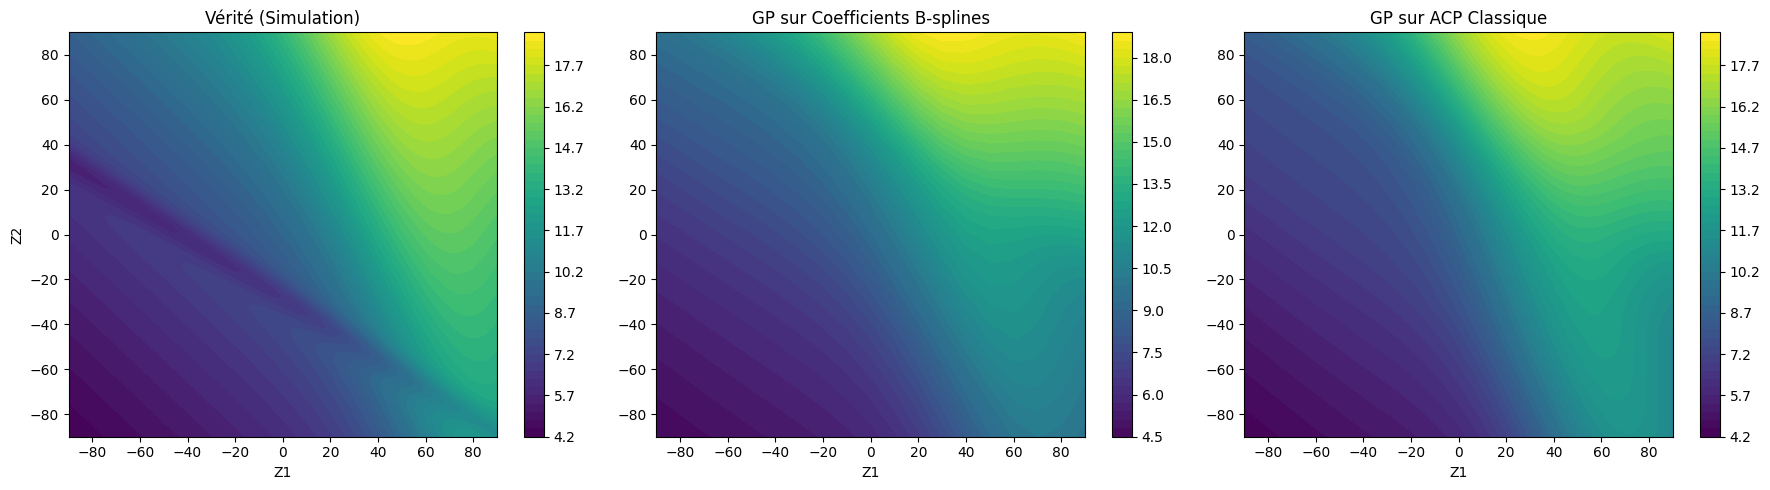

In [54]:
k = 7

# --- Reshape des champs
Y_true = np.reshape(y_test[k, :], (n_grid, n_grid))
Y_bs   = np.reshape(Y_test_reconstruct_Bsplines[k, :], (n_grid, n_grid))
Y_pca  = np.reshape(Y_test_reconstruct_ACP[k, :], (n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(Y_true.min(), Y_bs.min(), Y_pca.min())
vmax = max(Y_true.max(), Y_bs.max(), Y_pca.max())

# --- Plot côte à côte
plt.figure(figsize=(18, 5))

# Vérité
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, Y_true, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("Vérité (Simulation)")
plt.xlabel("Z1")
plt.ylabel("Z2")

# Reconstruction B-splines + GP
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, Y_bs, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("GP sur Coefficients B-splines")
plt.xlabel("Z1")

# Reconstruction ACP + GP
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, Y_pca, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("GP sur ACP Classique")
plt.xlabel("Z1")

plt.tight_layout()
plt.show()


# RMSE

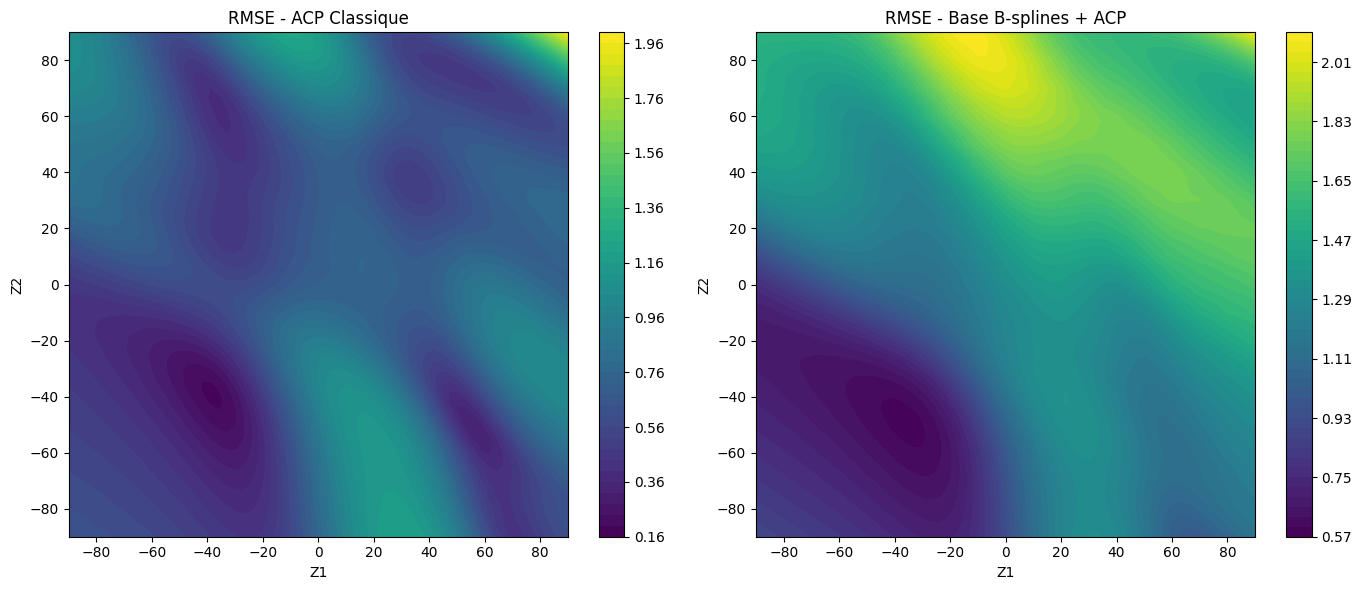

In [55]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
rmse_ACP = np.sqrt(np.mean((y_test - Y_test_reconstruct_ACP)**2, axis=0))
RMSE_map_ACP = rmse_ACP.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (B-splines)
rmse_BS = np.sqrt(np.mean((y_test - Y_test_reconstruct_Bsplines)**2, axis=0))
RMSE_map_BS = rmse_BS.reshape((n_grid, n_grid))

# --- Plot côte à côte
plt.figure(figsize=(14, 6))

# ACP classique
plt.subplot(1, 2, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 2, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()